<a href="https://colab.research.google.com/github/enVives/TFG/blob/main/EvaluacioArquitectures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import cv2
import random
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import kagglehub
import pandas as pd
import wandb
import pylab as pl
import json

from glob import glob
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_scoreS
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from sklearn.model_selection import train_test_split
from torchvision import transforms,models
from torch import nn
from torch.utils.data import Dataset
from google.colab import files
from IPython.display import clear_output,display
from google.colab.patches import cv2_imshow
from PIL import Image
from skimage import io
from google.colab import drive


WEIGHTSANDBIASES = True
DOWNLOAD = True
CROPPING = False
SEGMENTATION = True
CLAHE = False

# ORIGEN = '/content/drive/MyDrive/HAM10000/skin-cancer-mnist-ham10000/'



drive.mount('/content/drive')


if DOWNLOAD:
  !rm -rf /content/sample_data/*

  !kaggle datasets download -d "kmader/skin-cancer-mnist-ham10000"

  !unzip -o skin-cancer-mnist-ham10000.zip -d /content/sample_data/

  !kaggle datasets download -d "tschandl/ham10000-lesion-segmentations"

  !unzip -o ham10000-lesion-segmentations.zip -d /content/sample_data/

#471be466c8949671a46c67e7aad0d5a0ac8c9dad

if WEIGHTSANDBIASES:
  wandb.login()

#torch.cuda.default_stream(torch.device('cuda'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Streaming output truncated to the last 5000 lines.
  inflating: /content/sample_data/HAM10000_segmentations_lesion_tschandl/ISIC_0029321_segmentation.png  
  inflating: /content/sample_data/HAM10000_segmentations_lesion_tschandl/ISIC_0029322_segmentation.png  
  inflating: /content/sample_data/HAM10000_segmentations_lesion_tschandl/ISIC_0029323_segmentation.png  
  inflating: /content/sample_data/HAM10000_segmentations_lesion_tschandl/ISIC_0029324_segmentation.png  
  inflating: /content/sample_data/HAM10000_segmentations_lesion_tschandl/ISIC_0029325_segmentation.png  
  inflating: /content/sample_data/HAM10000_segmentations_lesion_tschandl/ISIC_0029326_segmentation.png  
  inflating: /content/sample_data/HAM10000_segmentations_lesion_tschandl/ISIC_0029327_segmentation.png  
  inflating: /content/sample_data/HAM10000_segmentations_lesion_tschandl/ISIC_0029328_segmentation.png  
  inflating: /content/sample_data/HAM10000_segmentations_lesion_tschandl/ISIC_0029329_segmentation.png  
  in

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: pjvivesmorey (pjvivesmorey-uib) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
# !mkdir -p ~/.kaggle
# !mv /content/kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json


!rm -rf /content/sample_data/*

!kaggle datasets download -d "kmader/skin-cancer-mnist-ham10000"

!unzip -o skin-cancer-mnist-ham10000.zip -d /content/sample_data/

In [ ]:

metadates = pd.read_csv('/content/sample_data/HAM10000_metadata.csv')
metadates = metadates.sort_values(by='image_id')
metadates.head()
print(metadates['dx'].value_counts())
print()
print(metadates['dx'].value_counts() / sum(metadates['dx'].value_counts()))

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

dx
nv       0.669496
mel      0.111133
bkl      0.109735
bcc      0.051323
akiec    0.032651
vasc     0.014179
df       0.011483
Name: count, dtype: float64


nv: melanocytic nevi

vasc: vascular lesions

mel:melanoma

df: dermatofibroma

bkl: benign keratosis-like lesions

bcc: basal cell carcinoma

akiec: Actinic keratoses and intraepithelial carcinoma / Bowen's disease

In [ ]:
class Formes(Dataset):
  #Classe on gestionarem les imatges dels fitxers
  dict_illnesses = {0 : 'nv', 1 : 'mel', 2 : 'bkl', 3 : 'bcc', 4 : 'akiec', 5 : 'vasc', 6 : 'df'}

  def __init__(self, images, labels, transform):
        super().__init__()
        self.paths = images
        self.labels = labels
        self.len = len(self.paths)
        self.transform = transform
        #Per defecte pens que el color pot extreure característiques importants, per tant en primer lloc
        #entrenarem les imatges de color
        self.greyscale = False

  def __len__(self):
        return self.len

  def __setmasks__(self,masks):
      self.masks = masks

  def __getmask__(self,i):
      return self.masks[i]

  def __lenmasks__(self):
    return len(self.masks)

  def __addlabel__(self,label):
    self.labels = np.append(self.labels,label)

  def __addPath__(self,path):
    self.paths = np.append(self.paths,path)

  def __getdist__(self):
    return pd.Series(self.labels).value_counts()

  def __getlabels__(self):
    classes = [[],[],[],[],[],[],[]]
    for i in range(len(self.labels)):
      classes[self.labels[i]].append(i) #afegim l'index
    return classes

  def __redistribute__(self,percentages):
    #percentages: [15,15,10,10,5,5] percentatges que volem pujar de la resta de classes llevat de nv
    threshold = 0.005  #percentatge de marge que deixam a la redistribució
    Ntarget = self.len
    classes = self.__getlabels__() #indexos de cada clase
    afegir = np.array([0,0,0,0,0,0],dtype=np.int64) # de nv mai haurem d'afegir

    nmel = len(classes[1]) #nombre inicial de cada clase
    nbkl = len(classes[2])
    nbcc = len(classes[3])
    nakiec = len(classes[4])
    nvasc = len(classes[5])
    ndf = len(classes[6])

    while True:

      suma_actual = afegir.sum()

      operacio = percentages[0]*Ntarget - nmel
      afegir[0] +=  operacio if operacio > 0 else 0
      nmel += operacio if operacio > 0 else 0

      operacio = percentages[1]*Ntarget - nbkl
      afegir[1] += operacio if operacio > 0 else 0
      nbkl += operacio if operacio > 0 else 0

      operacio = percentages[2]*Ntarget - nbcc
      afegir[2] += operacio if operacio > 0 else 0
      nbcc += operacio if operacio > 0 else 0

      operacio = percentages[3]*Ntarget - nakiec
      afegir[3] += operacio if operacio > 0 else 0
      nakiec += operacio if operacio > 0 else 0

      operacio = percentages[4]*Ntarget - nvasc
      afegir[4] += operacio if operacio > 0 else 0
      nvasc += operacio if operacio > 0 else 0

      operacio = percentages[5]*Ntarget - ndf
      afegir[5] += operacio if operacio > 0 else 0
      ndf += operacio if operacio > 0 else 0

      if (afegir.sum()-suma_actual) < Ntarget*threshold:
        break

      Ntarget += (afegir.sum()-suma_actual)

    #Quedaria afegir a les imatges les còpies
    for i in range(len(afegir)):
      for j in range(afegir[i]):

          self.__addPath__(self.paths[classes[i+1][random.randint(0, len(classes[i+1]) - 1)]])
          self.__addlabel__(i+1)

    self.len = len(self.labels)

  def __setgreyscale__(self,mode):
    self.greyscale = mode

  def __getpath__(self,index):
    return self.paths[index]

  def __getitem__(self, index):
      path = self.paths[index]
      label = self.labels[index]

      image = cv2.imread(path, cv2.IMREAD_GRAYSCALE if self.greyscale else cv2.IMREAD_COLOR)

      if SEGMENTATION:
        mask = cv2.imread(self.masks[index], cv2.IMREAD_GRAYSCALE)
        _, mask_binaria = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
        image = cv2.bitwise_and(image, image, mask=mask_binaria)

        non_black_pixels = np.where(image > 0)

        x_min, x_max = np.min(non_black_pixels[1]), np.max(non_black_pixels[1])
        y_min, y_max = np.min(non_black_pixels[0]), np.max(non_black_pixels[0])

        marge = 10
        if ((x_min - marge) >= 0):
            x_min = x_min - marge
        if ((x_max + marge) <= 224):
            x_max = x_max + marge

        if CROPPING:
          image = image[y_min:y_max, x_min:x_max]

        # print(cropped_image.shape)
        image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_CUBIC)

      #preprocessament
      if CLAHE:
        lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(8,8))
        l_clahe = clahe.apply(l)
        lab_clahe = cv2.merge((l_clahe, a, b))
        image = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)




      if self.greyscale:
        image = Image.fromarray(image, mode="L")
      else:
        image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

      image = self.transform(image)

      return image, label

In [ ]:
def calcula_mitjana_desviacio(img_files_path):
  mitjana = np.array([0.0, 0.0, 0.0], dtype=np.float64)
  desviacio = np.array([0.0, 0.0, 0.0], dtype=np.float64)

  x,y = 256,256
  pixels_totals_canal = len(img_files_path) * x * y

  for i in range(len(img_files_path)):
    imatge = cv2.imread(img_files_path[i])
    imatge = cv2.resize(imatge,(x,y))

    canal_b, canal_g, canal_r = cv2.split(imatge)

    mitjana += np.array([canal_r.sum(), canal_g.sum(), canal_b.sum()])
    #desviacio += np.array([(canal_r**2).sum(), (canal_g**2).sum(), (canal_b**2).sum()])

  mitjana = mitjana / pixels_totals_canal

  for i in range(len(img_files_path)):
    imatge = cv2.imread(img_files_path[i])
    imatge = cv2.resize(imatge,(x,y))

    canal_b, canal_g, canal_r = cv2.split(imatge)
    desviacio += np.array([((canal_r-mitjana[0])**2).sum(), ((canal_g-mitjana[1])**2).sum(), ((canal_b-mitjana[2])**2).sum()])


  desviacio = np.sqrt(desviacio / pixels_totals_canal)

  return mitjana,desviacio

In [ ]:
def load_sets(transformation_training,transformation_default,training_dist,valitation_dist,testing_dist,distribution):

  illnes_dictionary = {
      'nv': 'Melanocytic nevi',
      'mel': 'Melanoma',
      'bkl': 'Benign keratosis-like lesions ',
      'bcc': 'Basal cell carcinoma',
      'akiec': 'Actinic keratoses and intraepithelial carcinoma / Bowens disease',
      'vasc': 'Vascular lesions',
      'df': 'Dermatofibroma'
  }

  img_files_1 = sorted(glob('/content/sample_data/HAM10000_images_part_1/*'))
  img_files_2 = sorted(glob('/content/sample_data/HAM10000_images_part_2/*'))
  img_files = img_files_1 + img_files_2

  img_files = np.array(img_files)

  mask_files = sorted(glob('/content/sample_data/HAM10000_segmentations_lesion_tschandl/*'))

  imgid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in img_files}

  mask_path_dict = {os.path.splitext(os.path.basename(x))[0].replace('_segmentation', ''): x for x in mask_files}

  #print(mask_path_dict)

  #{'ISIC_0024306_segmentation': '/content/sample_data/HAM10000_segmentations_lesion_tschandl/ISIC_0024306_segmentation.png'

  metadates['path'] = metadates['image_id'].map(imgid_path_dict.get)
  metadates['mask_path'] = metadates['image_id'].map(mask_path_dict.get)

  metadates['illness'] = metadates['dx'].map(illnes_dictionary.get)
  metadates['illness_code'] = metadates['dx'].map({'nv': 0, 'mel': 1, 'bkl': 2, 'bcc': 3, 'akiec': 4, 'vasc': 5, 'df': 6})

  #Aquest illness_code s'utilitzarà com a label de la enfermetat

  img_number = len(img_files)

  X = metadates.drop('illness_code',axis= 1)
  y = metadates['illness_code']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testing_dist, random_state=42, stratify=y)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=valitation_dist/(training_dist+valitation_dist), random_state=42, stratify=y_train)

  #Una bona idea seria aplicar data augmentation al conjunt d'entrenament ja que les classes estan molt desbalancejades
  #Una altra bona idea seria emplear una funció de pèrdua que tengui en compte les classes desbalancejades.

  #Antes de guardar els datasets en classes Formes, hauriem de caluclar la mitjana i desviació típica de les imatges
  train_data = Formes(X_train['path'].to_numpy(),y_train.to_numpy(),transformation_training)
  test_data = Formes(X_test['path'].to_numpy(),y_test.to_numpy(),transformation_default)
  validation_data = Formes(X_val['path'].to_numpy(),y_val.to_numpy(),transformation_default)

  if SEGMENTATION:

    train_data.__setmasks__(X_train['mask_path'].to_numpy())
    test_data.__setmasks__(X_test['mask_path'].to_numpy())
    validation_data.__setmasks__(X_val['mask_path'].to_numpy())

  #prova1: [0.12,0.12,0.06,0.04,0.02,0.02]
  #prova2: [0.12,0.12,0.06,0.04,0.02,0.015]
  #prova3: [0.13,0.13,0.07,0.05,0.02,0.015]

  if distribution != None:
    train_data.__redistribute__(distribution)

  return train_data, validation_data,test_data


In [ ]:
def get_weights():

  #diseases = {'0': 0,'1':1,'2': 0,'3': 1,'4':1,'5':0,'6':0}

  valors = metadates['dx'].value_counts()
  illnesses = valors.keys()
  weights = np.zeros(len(illnesses))

  i = 0
  for x in illnesses:
    y = valors[x]
    weights[i] = valors.sum() / y
    i+= 1

  weights = weights / weights.sum()

  return (1 - (weights[1]+weights[3]+weights[4])) / (weights[1]+weights[3]+weights[4]) ,weights

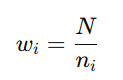

In [ ]:
#veure_imatges(train_data,std,mean)

Ara ja tenim el training preparat. El provarem amb el validation a continuació

##ENTRENAMENT

In [ ]:
def tria_model(numero_model,weights):
  if numero_model == 0:
    alexnetbinary = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)

    alexnetbinary.classifier = nn.Sequential(
    torch.nn.Linear(9216, 1024),
    nn.ReLU(),
    torch.nn.Linear(1024, 1024),
    nn.ReLU(),
    torch.nn.Linear(1024, 512),
    nn.ReLU(),
    torch.nn.Linear(512, 1)
    )
    pos_weight = torch.tensor(weights,device = device)
    # print(pos_weight.shape)
    # print(pos_weight)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    return alexnetbinary,loss_fn

  # elif numero_model == 1:
  #   resnetbinary = models.resnet50(weights="IMAGENET1K_V1")
  #   resnetbinary.fc = nn.Linear(in_features=2048, out_features=1)

  #   pos_weight = torch.tensor(weights,device = device)
  #   loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

  #   return resnetbinary,loss_fn

  elif numero_model == 1:
    resnetbinary = models.resnet152(weights="IMAGENET1K_V1")
    num_features = resnetbinary.fc.in_features
    resnetbinary.fc = nn.Linear(in_features=num_features, out_features=1)

    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    return resnetbinary,loss_fn

  elif numero_model == 2:
    googlenet = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1, aux_logits=True)
    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    googlenet.aux_logits = False

    num_features = googlenet.fc.in_features
    googlenet.fc = nn.Linear(in_features=num_features, out_features=1)

    return googlenet,loss_fn

  elif numero_model == 3:
    efficientnet = models.efficientnet_b1(weights='IMAGENET1K_V1')
    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    num_features = efficientnet.classifier[1].in_features
    efficientnet.classifier[1] = nn.Linear(in_features=num_features, out_features=1)

    return efficientnet,loss_fn

  elif numero_model == 4:

    alexnetmulticlass = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)
    alexnetmulticlass.classifier[6] = nn.Linear(in_features=4096, out_features=7)

    weights = torch.tensor(weights,device = device,dtype= torch.float32).squeeze(0)
    loss_fn = nn.CrossEntropyLoss(weight=weights)

    return alexnetmulticlass,loss_fn

  # elif numero_model == 6:

  #   resnetmulticlass = models.resnet50(weights="IMAGENET1K_V1")
  #   num_features = resnetmulticlass.fc.in_features
  #   resnetmulticlass.fc = nn.Linear(in_features=num_features, out_features=7)

  #   weights = torch.tensor(weights,device = device,dtype= torch.float32).squeeze(0)
  #   loss_fn = nn.CrossEntropyLoss(weight=weights)

  #   return resnetmulticlass,loss_fn

  elif numero_model == 5:
    resnetmulticlass152 = models.resnet152(weights="IMAGENET1K_V1")
    num_features = resnetmulticlass152.fc.in_features
    resnetmulticlass152.fc = nn.Linear(in_features=num_features, out_features=7)

    weights = torch.tensor(weights,device = device,dtype= torch.float32).squeeze(0)
    loss_fn = nn.CrossEntropyLoss(weight=weights)

    return resnetmulticlass152,loss_fn

  elif numero_model == 6:

    googlenetmulticlass = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1)

    weights = torch.tensor(weights,device = device,dtype= torch.float32).squeeze(0)
    loss_fn = nn.CrossEntropyLoss(weight=weights)

    num_features = googlenetmulticlass.fc.in_features
    googlenetmulticlass.fc = nn.Linear(in_features=num_features, out_features=1)

    return googlenetmulticlass,loss_fn

  elif numero_model == 7:

    efficientnetmulticlass = models.efficientnet_b1(weights='IMAGENET1K_V1')

    weights = torch.tensor(weights,device = device,dtype= torch.float32).squeeze(0)
    loss_fn = nn.CrossEntropyLoss(weight=weights)

    num_features = efficientnetmulticlass.classifier[1].in_features
    efficientnetmulticlass.classifier[1] = nn.Linear(in_features=num_features, out_features=7)

    return efficientnetmulticlass,loss_fn



In [ ]:
def converteix_a_binari(target):
  #{'nv': 0, 'mel': 1, 'bkl': 2, 'bcc': 3, 'akiec': 4, 'vasc': 5, 'df': 6}
  diseases = {'0': 0,'1':1,'2': 0,'3': 1,'4':1,'5':0,'6':0}
  target = ([[str(num.item())] for num in target])

  mapped_tensor = torch.tensor([[diseases[num[0]]] for num in target])
  return mapped_tensor

In [ ]:
def train(model,loss_fn,dataloader,optimizer,epoch,device):

  train_acc = 0
  train_f1 = 0
  train_recall = 0
  train_precision = 0
  train_loss = 0

  for batch_num, (input_img, target) in tqdm(enumerate(dataloader), desc=f"Batches (Època {epoch})"):
        model.train()
        optimizer.zero_grad()

        input_img = input_img.to(device)
        output = model(input_img.to(device))

        #print(output.shape[1])

        if output.shape[1] > 1: #multiclass
          a = 1
        else: #binary
          target = torch.unsqueeze(target, 1) #separa [1,2,3,4] en [[1],[2],[3]]
          target = converteix_a_binari(target) #només si volem saber si la enfermetat es benigna o no

        if output.shape[1] > 1:
          target = target.to(device)
          loss = loss_fn(output, target)
        else:
          target = target.to(device)
          loss = loss_fn(output, target.float())


        if output.shape[1] > 1:
          output = torch.softmax(output,dim = 1) #calculam les probabilitats de cada classe a partir dels logits
          output = output.argmax(dim=1) #obtenim la classe que té la probabilitat més alta de les 7
          output = output.cpu().detach().numpy()
        else:
          output = torch.sigmoid(output)   #funció sigmoide per al cas binari
          output = (output.cpu().detach().numpy() > 0.5).astype(int)

        target = target.cpu().detach().numpy()

        model.zero_grad()
        loss.backward()

        with torch.no_grad():
            optimizer.step()

        #print(f"Pèrdua entrenament batch: {batch_num} epoch: {epoch+1}  train_loss: {loss.item()}")
        train_acc += accuracy_score(target,output)
        train_f1 += f1_score(target,output,average='weighted',zero_division=1)
        train_recall += recall_score(target,output,average='weighted',zero_division=1)
        train_precision += precision_score(target,output,average='weighted',zero_division=1)
        train_loss += loss.item()

  return train_acc,train_f1,train_recall,train_precision,train_loss


In [ ]:
def validate(model,loss_fn,data_loader,device):
  val_acc = 0
  val_f1 = 0
  val_recall = 0
  val_precision = 0
  val_loss = 0

  model.eval()
  with torch.no_grad():
      for batch_num, (input_img, target) in enumerate(data_loader):

            input_img = input_img.to(device)
            output = model(input_img)


            if output.shape[1] > 1: #multiclass
              a = 1
            else: #binary
              target = torch.unsqueeze(target, 1) #separa [1,2,3,4] en [[1],[2],[3]]
              target = converteix_a_binari(target) #només si volem saber si la enfermetat es benigna o no

            if output.shape[1] > 1:
              target = target.to(device)
              loss = loss_fn(output, target)
            else:
              target = target.to(device)
              loss = loss_fn(output, target.float())


            if output.shape[1] > 1:
              output = torch.softmax(output,dim = 1) #calculam les probabilitats de cada classe a partir dels logits
              output = output.argmax(dim=1) #obtenim la classe que té la probabilitat més alta de les 7
              output = output.cpu().detach().numpy()
            else:
              output = torch.sigmoid(output)   #funció sigmoide per al cas binari
              output = (output.cpu().detach().numpy() > 0.5).astype(int)


            target = target.cpu().detach().numpy()

            val_acc  += accuracy_score(target,output)
            val_f1 += f1_score(target,output,average='weighted',zero_division=1)
            val_recall += recall_score(target,output,average='weighted',zero_division=1)
            val_precision += precision_score(target,output,average='weighted',zero_division=1)

            val_loss += loss.item()

  return val_acc,val_f1,val_recall,val_precision,val_loss

In [ ]:
from ast import And
def execute(model,loss_fn,train_loader,val_loader,test_loader,optimizer,epochs,device):

  t_loss = np.zeros(epochs)
  v_loss = np.zeros(epochs)
  acc_t = np.zeros(epochs)
  acc_v = np.zeros(epochs)
  f1_t = np.zeros(epochs)
  f1_v = np.zeros(epochs)
  recall_t = np.zeros(epochs)
  recall_v = np.zeros(epochs)


  interval = 5
  requerit = 0.010
  last_loss = float('inf')

  epoch_number = 0

  pbar = tqdm(range(1, epochs + 1))  # tdqm permet tenir text dinàmic

  for epoch in pbar:

      train_loss = 0
      train_acc = 0
      train_precision = 0
      train_f1 = 0
      train_recall = 0
      val_acc = 0
      val_recall = 0
      val_f1 = 0
      val_loss = 0
      val_precision = 0

      batch_num = 1

      train_acc,train_f1,train_recall,train_precision,train_loss = train(model,loss_fn,train_loader,optimizer,epoch,device)
      val_acc,val_f1,val_recall,val_precision,val_loss  = validate(model,loss_fn,val_loader,device)

      if WEIGHTSANDBIASES:

        training_metrics = {"train/train_loss": train_loss/len(train_loader),
                        "train/train_acc":train_acc/len(train_loader),
                        "train/train_f1":train_f1/len(train_loader),
                        "train/train_recall":train_recall/len(train_loader),
                        "train/train_precision":train_precision/len(train_loader)}

        val_metrics = {"val/val_loss": val_loss/len(val_loader),
                      "val/val_acc":val_acc/len(val_loader),
                      "val/val_f1":val_f1/len(val_loader),
                      "val/val_recall": val_recall/len(val_loader),
                      "val/val_precision": val_precision/len(val_loader)}

        wandb.log({**training_metrics, **val_metrics})

      # RESULTATS
      train_loss /= len(train_loader)
      train_acc /= len(train_loader)
      train_f1 /= len(train_loader)
      train_recall /= len(train_loader)
      train_precision /= len(train_loader)

      print(f"Pèrdua entrenament epoch: {epoch}  train_loss: {train_loss}")
      print(f"Accuracy train epoch: {epoch}  train_acc: {train_acc}")
      print(f"F1 train epoch: {epoch}  train_f1: {train_f1}")
      print(f"Recall train epoch: {epoch}  train_recall: {train_recall}")

      val_loss /= len(val_loader)
      val_acc /= len(val_loader)
      val_f1 /= len(val_loader)
      val_recall /= len(val_loader)
      val_precision /= len(val_loader)

      print()
      print()
      print(f"Pèrdua validació epoch: {epoch}  val_loss: {val_loss}")
      print(f"Accuracy val epoch: {epoch}  val_acc: {val_acc}")
      print(f"F1 val epoch: {epoch}  val_f1: {val_f1}")
      print(f"Recall val epoch: {epoch}  val_recall: {val_recall}")
      print(f"Recall val epoch: {epoch}  val_precision: {val_precision}")



      if interval > 0:
        interval -= 1

      if interval == 0:
        if last_loss - requerit < train_loss:
            print("Early Stopping, no hem reduït ni un 0.03 de loss respecte 10 èpoques!!")
            break
        else:
          interval = 5
          last_loss = train_loss

  return model

In [ ]:
def test(model,dataloader,weights_dir,loss_fn,device):

  model.load_state_dict(torch.load(weights_dir))

  test_acc = 0
  test_f1 = 0
  test_recall = 0
  test_precision = 0
  test_loss = 0

  json_obj = []

  model.eval()

  with torch.no_grad():
      for batch_num, (input_img, target) in enumerate(dataloader):

            input_img = input_img.to(device)
            output = model(input_img)

            dades = {}

            if output.shape[1] > 1: #multiclass
              a = 1
            else: #binary
              target = torch.unsqueeze(target, 1) #separa [1,2,3,4] en [[1],[2],[3]]
              target = converteix_a_binari(target) #només si volem saber si la enfermetat es benigna o no

            if output.shape[1] > 1:
              target = target.to(device)
              loss = loss_fn(output, target)
            else:
              target = target.to(device)
              loss = loss_fn(output, target.float())


            if output.shape[1] > 1:
              output = torch.softmax(output,dim = 1) #calculam les probabilitats de cada classe a partir dels logits

              dades["output"] = output.cpu().detach().tolist() #guardam les probabilitats de l'output

              output = output.argmax(dim=1) #obtenim la classe que té la probabilitat més alta de les 7
              output = output.cpu().detach().numpy()
            else:
              output = torch.sigmoid(output)   #funció sigmoide per al cas binari

              dades["output"] = output.cpu().detach().tolist() #guardam les probabilitats de l'output

              output = (output.cpu().detach().numpy() > 0.5).astype(int)

            dades["target"] = target.cpu().detach().tolist()

            target = target.cpu().detach().numpy()

            dades["top1-accuracy"] = accuracy_score(target,output)
            test_acc  += dades["top1-accuracy"]
            dades["f1-score"] = f1_score(target,output,average='weighted',zero_division=1)
            test_f1 += dades["f1-score"]
            dades["recall"] = recall_score(target,output,average='weighted',zero_division=1)
            test_recall += dades["recall"]
            dades["precision"] = precision_score(target,output,average='weighted',zero_division=1)
            test_precision += dades["precision"]

            dades["loss"] = loss.item()
            test_loss += dades["loss"]

            json_obj.append(dades)


  return json_obj

In [ ]:
def veure_imatges(train_data):
  for i in range(len(train_data)):
    path = train_data.__getpath__(i)
    clean_img = cv2.imread(path)
    mean, std = cv2.meanStdDev(clean_img)

    clean_img = cv2.resize(clean_img, (224, 224))
    clean_img = torch.tensor(clean_img).permute(2, 0, 1)  # Convert to (C, H, W)

    print(clean_img.shape)

    imatge,label = train_data.__getitem__(i)
    print(imatge.shape)
    std = std.flatten()
    mean = mean.flatten()
    imatge = imatge * (std[:, None, None]) + (mean[:, None, None])

    img_numpy = imatge.permute(1, 2, 0).numpy()  # Change from (C, H, W) to (H, W, C)
    clean_img = clean_img.permute(1, 2, 0).numpy() #clean_img no es un torch

    combined_image = np.concatenate((img_numpy, clean_img), axis=1)
    cv2_imshow(combined_image)

    time.sleep(5)
    clear_output(wait=True)

In [ ]:
from itertools import product
BINARY = True #Si volem que el resultat de la classificació sigui 0 i 1

architectures = {'alexnet': 0,'resnet152':1,'inceptionv3':2,'efficientnetb1':3,'alexnetmulticlass':4,'resnet152multiclass':5,'inceptionv3multiclass':6,'efficientnetb1multiclass':7}
nom_model = 'resnet152multiclass'
MODEL = architectures[nom_model]

TRAINING = 0.80
VALIDATION = 0.10
TESTING = 0.10
SIZE = 224


mean = torch.tensor([194.57463374, 139.13953272, 145.36132088]) /255 #rgb
std = torch.tensor([35.92275236, 38.90347617, 43.33101831]) / 255

TRANSFORMATIONS = []
DISTRIBUTIONS = None

if SEGMENTATION == False:
  transform = transforms.Compose([
      transforms.Resize((SIZE,SIZE)),
      transforms.ToTensor(),
      transforms.Normalize(mean = mean, std=std)
  ])

  transform_training = transforms.Compose([
      transforms.Resize((SIZE,SIZE)),
      transforms.RandomHorizontalFlip(p=0.3),
      transforms.RandomVerticalFlip(p=0.3),
      transforms.RandomRotation(degrees=20),
      transforms.ToTensor(),
      transforms.Normalize(mean = mean, std=std),
  ])
else:
  transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean = mean, std=std)
  ])

  transform_training = transforms.Compose([
      transforms.RandomHorizontalFlip(p=0.3),
      transforms.RandomVerticalFlip(p=0.3),
      transforms.RandomRotation(degrees=20),
      transforms.ToTensor(),
      transforms.Normalize(mean = mean, std=std),
  ])

CLAHE = False
train_data,validation_data,test_data = load_sets(transform_training,transform,TRAINING,VALIDATION,TESTING,DISTRIBUTIONS)


EPOCHS = 50
batch_size = 32

binary_weights, multiple_weights = get_weights()

if MODEL < 4:
  weights = binary_weights
else:
  weights = multiple_weights

print(weights)
learning_rate  = 1e-5


train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

model,loss_fn = tria_model(MODEL,weights)


optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model.to(device)

projectes = ['Ham10000-AlexnetBinary','Ham1000-Resnet152Binary','Ham10000-Inceptionv3Binary','Ham10000-EfficientNetB1Binary',
              'Ham10000-AlexnetMulticlass','Ham10000Resnet152Multiclass','Ham10000-Inceptionv3Multiclass','Ham10000-EfficientNetB1Multiclass']

parametres_training = {
                "epochs": EPOCHS,
                "batch_size": batch_size,
                "lr": learning_rate,
                "trsize":len(train_loader),
                "trdist":TRAINING,
                "vsize":len(val_loader),
                "vdist":VALIDATION,
                "testsize":len(test_loader),
                "testdist": TESTING,
                "loss_weights":str(weights),
                "SEGMENTATION": SEGMENTATION,
                "CROPPING": CROPPING,
                "CLAHE": CLAHE,
                "data_augmentation": str(transform_training)
}

carpeta_drive = '/content/drive/MyDrive/Runs/' + projectes[MODEL]
os.makedirs(carpeta_drive, exist_ok=True) #cream la carpeta si no existeix

current_runs = len([d for d in os.listdir(carpeta_drive) if os.path.isdir(os.path.join(carpeta_drive, d))]) #número d'execucions fetes de cada model

#cada execució tindrà la seva carpeta numerada

json_object = json.dumps(parametres_training,indent = 2)

#cream la carpeta de l'execució

num_execucio = str(current_runs)
carpeta_execucio = carpeta_drive+"/"+ num_execucio
os.makedirs(carpeta_execucio,exist_ok=True)

#afegim la informació d'entrenament a la carpeta
with open(carpeta_execucio+"/training_info.json", "w") as outfile:
  outfile.write(json_object)


if WEIGHTSANDBIASES:
    wandb.init(
            project=projectes[MODEL],
            config={
                "epochs": EPOCHS,
                "batch_size": batch_size,
                "lr": learning_rate,
                "trsize":len(train_loader),
                "trdist":TRAINING,
                "vsize":len(val_loader),
                "vdist":VALIDATION,
                "weights":weights,
                "CLAHE": CLAHE,
                })
    config = wandb.config
    print(config)

#guardam els pesos a la carpeta de drive
best_model = execute(model,loss_fn,train_loader,val_loader,test_loader,optimizer,EPOCHS,device)
carpeta_pesos = carpeta_execucio+'/pesos_'+nom_model+'_'+num_execucio+'.pt'
torch.save(model.state_dict(), carpeta_pesos )

#també guardam els resultats del test a la carpeta de drive
carpeta_pesos = carpeta_execucio+'/pesos_'+nom_model+'_'+str(current_runs)+'.pt'

resultats = test(model,test_loader,carpeta_pesos,loss_fn,device)

with open(carpeta_execucio+"/testing_info.json", "w") as outfile:
    json.dump(resultats, outfile, indent=3)


wandb.finish()

[0.00657042 0.03958192 0.04008614 0.08570948 0.13472377 0.31024417
 0.3830841 ]


Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:02<00:00, 95.1MB/s]


{'epochs': 50, 'batch_size': 32, 'lr': 1e-05, 'trsize': 251, 'trdist': 0.8, 'vsize': 32, 'vdist': 0.1, 'weights': [0.0065704208816761995, 0.03958191555403316, 0.04008614377765142, 0.08570947862186559, 0.13472376761969088, 0.31024416909604874, 0.383084104449034], 'CLAHE': False}


  0%|          | 0/50 [00:00<?, ?it/s]

Batches (Època 1): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 1  train_loss: 1.4211108176356768
Accuracy train epoch: 1  train_acc: 0.47654835204636
F1 train epoch: 1  train_f1: 0.5365484945781042
Recall train epoch: 1  train_recall: 0.47654835204636


Pèrdua validació epoch: 1  val_loss: 1.0698433443903923
Accuracy val epoch: 1  val_acc: 0.637890625
F1 val epoch: 1  val_f1: 0.6803104007186068
Recall val epoch: 1  val_recall: 0.637890625
Recall val epoch: 1  val_precision: 0.7989181285811391


Batches (Època 2): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 2  train_loss: 0.9404464588459744
Accuracy train epoch: 2  train_acc: 0.669865990583122
F1 train epoch: 2  train_f1: 0.71712494303959
Recall train epoch: 2  train_recall: 0.669865990583122


Pèrdua validació epoch: 2  val_loss: 0.8678676560521126
Accuracy val epoch: 2  val_acc: 0.7083984375
F1 val epoch: 2  val_f1: 0.7377175047862117
Recall val epoch: 2  val_recall: 0.7083984375
Recall val epoch: 2  val_precision: 0.8103521376960766


Batches (Època 3): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 3  train_loss: 0.7576921820878033
Accuracy train epoch: 3  train_acc: 0.6948908909815283
F1 train epoch: 3  train_f1: 0.7374200953106196
Recall train epoch: 3  train_recall: 0.6948908909815283


Pèrdua validació epoch: 3  val_loss: 0.7975962432101369
Accuracy val epoch: 3  val_acc: 0.74765625
F1 val epoch: 3  val_f1: 0.7738346916402834
Recall val epoch: 3  val_recall: 0.74765625
Recall val epoch: 3  val_precision: 0.8329073620383649


Batches (Època 4): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 4  train_loss: 0.661759769714686
Accuracy train epoch: 4  train_acc: 0.7363500543281419
F1 train epoch: 4  train_f1: 0.7739576297359615
Recall train epoch: 4  train_recall: 0.7363500543281419


Pèrdua validació epoch: 4  val_loss: 0.7318723928183317
Accuracy val epoch: 4  val_acc: 0.719140625
F1 val epoch: 4  val_f1: 0.7529106454059485
Recall val epoch: 4  val_recall: 0.719140625
Recall val epoch: 4  val_precision: 0.8388851694260279


Batches (Època 5): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 5  train_loss: 0.5864412465774681
Accuracy train epoch: 5  train_acc: 0.7537690148496922
F1 train epoch: 5  train_f1: 0.787759941481376
Recall train epoch: 5  train_recall: 0.7537690148496922


Pèrdua validació epoch: 5  val_loss: 0.664858739823103
Accuracy val epoch: 5  val_acc: 0.74765625
F1 val epoch: 5  val_f1: 0.7734624288485306
Recall val epoch: 5  val_recall: 0.74765625
Recall val epoch: 5  val_precision: 0.8408000676284768


Batches (Època 6): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 6  train_loss: 0.4929615291822479
Accuracy train epoch: 6  train_acc: 0.7689582578775805
F1 train epoch: 6  train_f1: 0.8007226114584354
Recall train epoch: 6  train_recall: 0.7689582578775805


Pèrdua validació epoch: 6  val_loss: 0.6307787904515862
Accuracy val epoch: 6  val_acc: 0.7740234375
F1 val epoch: 6  val_f1: 0.7992736588740723
Recall val epoch: 6  val_recall: 0.7740234375
Recall val epoch: 6  val_precision: 0.8535896385145052


Batches (Època 7): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 7  train_loss: 0.445375296580364
Accuracy train epoch: 7  train_acc: 0.7894784498370155
F1 train epoch: 7  train_f1: 0.8180306538332421
Recall train epoch: 7  train_recall: 0.7894784498370155


Pèrdua validació epoch: 7  val_loss: 0.6204004967585206
Accuracy val epoch: 7  val_acc: 0.7857421875
F1 val epoch: 7  val_f1: 0.8075546889407914
Recall val epoch: 7  val_recall: 0.7857421875
Recall val epoch: 7  val_precision: 0.8696164984829988


Batches (Època 8): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 8  train_loss: 0.44781896005944904
Accuracy train epoch: 8  train_acc: 0.7893765845708076
F1 train epoch: 8  train_f1: 0.8182082754545434
Recall train epoch: 8  train_recall: 0.7893765845708076


Pèrdua validació epoch: 8  val_loss: 0.6029159342870116
Accuracy val epoch: 8  val_acc: 0.784765625
F1 val epoch: 8  val_f1: 0.798271893239617
Recall val epoch: 8  val_recall: 0.784765625
Recall val epoch: 8  val_precision: 0.8440255254984643


Batches (Època 9): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 9  train_loss: 0.4100464740656762
Accuracy train epoch: 9  train_acc: 0.7969598877218399
F1 train epoch: 9  train_f1: 0.8253434196162047
Recall train epoch: 9  train_recall: 0.7969598877218399


Pèrdua validació epoch: 9  val_loss: 0.5560523655731231
Accuracy val epoch: 9  val_acc: 0.7728515625
F1 val epoch: 9  val_f1: 0.799488066633827
Recall val epoch: 9  val_recall: 0.7728515625
Recall val epoch: 9  val_precision: 0.8663801328679771


Batches (Època 10): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 10  train_loss: 0.36276498555662146
Accuracy train epoch: 10  train_acc: 0.8161105577689243
F1 train epoch: 10  train_f1: 0.8401621381290859
Recall train epoch: 10  train_recall: 0.8161105577689243


Pèrdua validació epoch: 10  val_loss: 0.5919475515838712
Accuracy val epoch: 10  val_acc: 0.775
F1 val epoch: 10  val_f1: 0.7979207339522397
Recall val epoch: 10  val_recall: 0.775
Recall val epoch: 10  val_precision: 0.8577946553172702


Batches (Època 11): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 11  train_loss: 0.33195507780192385
Accuracy train epoch: 11  train_acc: 0.8286965773270554
F1 train epoch: 11  train_f1: 0.8516632472946148
Recall train epoch: 11  train_recall: 0.8286965773270554


Pèrdua validació epoch: 11  val_loss: 0.6046479234937578
Accuracy val epoch: 11  val_acc: 0.7962890625
F1 val epoch: 11  val_f1: 0.8157221190261131
Recall val epoch: 11  val_recall: 0.7962890625
Recall val epoch: 11  val_precision: 0.8719490436319812


Batches (Època 12): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 12  train_loss: 0.28931254727313244
Accuracy train epoch: 12  train_acc: 0.8428898044186889
F1 train epoch: 12  train_f1: 0.864023463722933
Recall train epoch: 12  train_recall: 0.8428898044186889


Pèrdua validació epoch: 12  val_loss: 0.5435273195616901
Accuracy val epoch: 12  val_acc: 0.8111328125
F1 val epoch: 12  val_f1: 0.8312420295603337
Recall val epoch: 12  val_recall: 0.8111328125
Recall val epoch: 12  val_precision: 0.8775517368623836


Batches (Època 13): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 13  train_loss: 0.31076869932541334
Accuracy train epoch: 13  train_acc: 0.8396753893516842
F1 train epoch: 13  train_f1: 0.8607420399883626
Recall train epoch: 13  train_recall: 0.8396753893516842


Pèrdua validació epoch: 13  val_loss: 0.5638877509627491
Accuracy val epoch: 13  val_acc: 0.8013671875
F1 val epoch: 13  val_f1: 0.8184953165174091
Recall val epoch: 13  val_recall: 0.8013671875
Recall val epoch: 13  val_precision: 0.8753377676205051


Batches (Època 14): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 14  train_loss: 0.2635554022997974
Accuracy train epoch: 14  train_acc: 0.8495110467222021
F1 train epoch: 14  train_f1: 0.8695421586765584
Recall train epoch: 14  train_recall: 0.8495110467222021


Pèrdua validació epoch: 14  val_loss: 0.7125297754537314
Accuracy val epoch: 14  val_acc: 0.7990234375
F1 val epoch: 14  val_f1: 0.8180506618645261
Recall val epoch: 14  val_recall: 0.7990234375
Recall val epoch: 14  val_precision: 0.8765110768212526


Batches (Època 15): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 15  train_loss: 0.2537140837050529
Accuracy train epoch: 15  train_acc: 0.8657076240492575
F1 train epoch: 15  train_f1: 0.883978781513881
Recall train epoch: 15  train_recall: 0.8657076240492575


Pèrdua validació epoch: 15  val_loss: 0.5514435758814216
Accuracy val epoch: 15  val_acc: 0.8173828125
F1 val epoch: 15  val_f1: 0.8350751593579636
Recall val epoch: 15  val_recall: 0.8173828125
Recall val epoch: 15  val_precision: 0.8845763717036703


Batches (Època 16): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 16  train_loss: 0.21786997370807773
Accuracy train epoch: 16  train_acc: 0.8781578232524447
F1 train epoch: 16  train_f1: 0.8946637520484073
Recall train epoch: 16  train_recall: 0.8781578232524447


Pèrdua validació epoch: 16  val_loss: 0.6017937958240509
Accuracy val epoch: 16  val_acc: 0.80390625
F1 val epoch: 16  val_f1: 0.821217583479072
Recall val epoch: 16  val_recall: 0.80390625
Recall val epoch: 16  val_precision: 0.8744300642288888


Batches (Època 17): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 17  train_loss: 0.22943394537644082
Accuracy train epoch: 17  train_acc: 0.8762563382832307
F1 train epoch: 17  train_f1: 0.8922070839398821
Recall train epoch: 17  train_recall: 0.8762563382832307


Pèrdua validació epoch: 17  val_loss: 0.5393040683120489
Accuracy val epoch: 17  val_acc: 0.8177734375
F1 val epoch: 17  val_f1: 0.8299770264922385
Recall val epoch: 17  val_recall: 0.8177734375
Recall val epoch: 17  val_precision: 0.8790767630997472


Batches (Època 18): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 18  train_loss: 0.19362549875599455
Accuracy train epoch: 18  train_acc: 0.8884801702281782
F1 train epoch: 18  train_f1: 0.9035966504781885
Recall train epoch: 18  train_recall: 0.8884801702281782


Pèrdua validació epoch: 18  val_loss: 0.517772862687707
Accuracy val epoch: 18  val_acc: 0.8099609375
F1 val epoch: 18  val_f1: 0.8243498042441842
Recall val epoch: 18  val_recall: 0.8099609375
Recall val epoch: 18  val_precision: 0.86374035561266


Batches (Època 19): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 19  train_loss: 0.17940105954222232
Accuracy train epoch: 19  train_acc: 0.8926906012314378
F1 train epoch: 19  train_f1: 0.9064790871591432
Recall train epoch: 19  train_recall: 0.8926906012314378


Pèrdua validació epoch: 19  val_loss: 0.5436157583026215
Accuracy val epoch: 19  val_acc: 0.83125
F1 val epoch: 19  val_f1: 0.8441938821785065
Recall val epoch: 19  val_recall: 0.83125
Recall val epoch: 19  val_precision: 0.8852214314496938


Batches (Època 20): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 20  train_loss: 0.2004384155722847
Accuracy train epoch: 20  train_acc: 0.8948184534588917
F1 train epoch: 20  train_f1: 0.9088666514194356
Recall train epoch: 20  train_recall: 0.8948184534588917


Pèrdua validació epoch: 20  val_loss: 0.5990479667671025
Accuracy val epoch: 20  val_acc: 0.8228515625
F1 val epoch: 20  val_f1: 0.8369097071420788
Recall val epoch: 20  val_recall: 0.8228515625
Recall val epoch: 20  val_precision: 0.8806942337418343


Batches (Època 21): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 21  train_loss: 0.2216519532999788
Accuracy train epoch: 21  train_acc: 0.8887065374864179
F1 train epoch: 21  train_f1: 0.9043695830385723
Recall train epoch: 21  train_recall: 0.8887065374864179


Pèrdua validació epoch: 21  val_loss: 0.5799572702962905
Accuracy val epoch: 21  val_acc: 0.83359375
F1 val epoch: 21  val_f1: 0.8340985796025974
Recall val epoch: 21  val_recall: 0.83359375
Recall val epoch: 21  val_precision: 0.8716087953292112


Batches (Època 22): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 22  train_loss: 0.1655981004149078
Accuracy train epoch: 22  train_acc: 0.9007719123505976
F1 train epoch: 22  train_f1: 0.9155773349838122
Recall train epoch: 22  train_recall: 0.9007719123505976


Pèrdua validació epoch: 22  val_loss: 0.5712353102862835
Accuracy val epoch: 22  val_acc: 0.8201171875
F1 val epoch: 22  val_f1: 0.8353495971087395
Recall val epoch: 22  val_recall: 0.8201171875
Recall val epoch: 22  val_precision: 0.876514529273841


Batches (Època 23): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 23  train_loss: 0.1448800995560044
Accuracy train epoch: 23  train_acc: 0.9117620427381383
F1 train epoch: 23  train_f1: 0.9238857998692185
Recall train epoch: 23  train_recall: 0.9117620427381383


Pèrdua validació epoch: 23  val_loss: 0.7012509503401816
Accuracy val epoch: 23  val_acc: 0.8359375
F1 val epoch: 23  val_f1: 0.8406919484414125
Recall val epoch: 23  val_recall: 0.8359375
Recall val epoch: 23  val_precision: 0.8757117773802021


Batches (Època 24): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 24  train_loss: 0.16532893215428549
Accuracy train epoch: 24  train_acc: 0.9068838283230714
F1 train epoch: 24  train_f1: 0.9207931618244616
Recall train epoch: 24  train_recall: 0.9068838283230714


Pèrdua validació epoch: 24  val_loss: 0.7358182113384828
Accuracy val epoch: 24  val_acc: 0.836328125
F1 val epoch: 24  val_f1: 0.8452511598964181
Recall val epoch: 24  val_recall: 0.836328125
Recall val epoch: 24  val_precision: 0.8837633655994758


Batches (Època 25): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 25  train_loss: 0.12994760714204187
Accuracy train epoch: 25  train_acc: 0.9239292828685259
F1 train epoch: 25  train_f1: 0.9335195576605293
Recall train epoch: 25  train_recall: 0.9239292828685259


Pèrdua validació epoch: 25  val_loss: 0.6710764996241778
Accuracy val epoch: 25  val_acc: 0.8416015625
F1 val epoch: 25  val_f1: 0.8496951179067488
Recall val epoch: 25  val_recall: 0.8416015625
Recall val epoch: 25  val_precision: 0.8918673999400729


Batches (Època 26): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 26  train_loss: 0.1358905381326419
Accuracy train epoch: 26  train_acc: 0.922808764940239
F1 train epoch: 26  train_f1: 0.933388126186692
Recall train epoch: 26  train_recall: 0.922808764940239


Pèrdua validació epoch: 26  val_loss: 0.7092901836149395
Accuracy val epoch: 26  val_acc: 0.8412109375
F1 val epoch: 26  val_f1: 0.8535224266071932
Recall val epoch: 26  val_recall: 0.8412109375
Recall val epoch: 26  val_precision: 0.8904929378760353


Batches (Època 27): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 27  train_loss: 0.10695442252336033
Accuracy train epoch: 27  train_acc: 0.9320445490764215
F1 train epoch: 27  train_f1: 0.9400784784580885
Recall train epoch: 27  train_recall: 0.9320445490764215


Pèrdua validació epoch: 27  val_loss: 0.6863721127156168
Accuracy val epoch: 27  val_acc: 0.8453125
F1 val epoch: 27  val_f1: 0.8468409395090642
Recall val epoch: 27  val_recall: 0.8453125
Recall val epoch: 27  val_precision: 0.8766067839271088


Batches (Època 28): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 28  train_loss: 0.12174280385943166
Accuracy train epoch: 28  train_acc: 0.9332782506338283
F1 train epoch: 28  train_f1: 0.9424759355867771
Recall train epoch: 28  train_recall: 0.9332782506338283


Pèrdua validació epoch: 28  val_loss: 0.6980278512928635
Accuracy val epoch: 28  val_acc: 0.8298828125
F1 val epoch: 28  val_f1: 0.8407285708772072
Recall val epoch: 28  val_recall: 0.8298828125
Recall val epoch: 28  val_precision: 0.8873882815092634


Batches (Època 29): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 29  train_loss: 0.11886713634137494
Accuracy train epoch: 29  train_acc: 0.9301543824701195
F1 train epoch: 29  train_f1: 0.9402679740905279
Recall train epoch: 29  train_recall: 0.9301543824701195


Pèrdua validació epoch: 29  val_loss: 0.7551679121679626
Accuracy val epoch: 29  val_acc: 0.837890625
F1 val epoch: 29  val_f1: 0.8474219844779789
Recall val epoch: 29  val_recall: 0.837890625
Recall val epoch: 29  val_precision: 0.8865069612062828


Batches (Època 30): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 30  train_loss: 0.10464623899558982
Accuracy train epoch: 30  train_acc: 0.9370133103947845
F1 train epoch: 30  train_f1: 0.9453564482143478
Recall train epoch: 30  train_recall: 0.9370133103947845


Pèrdua validació epoch: 30  val_loss: 0.6170086204074323
Accuracy val epoch: 30  val_acc: 0.8189453125
F1 val epoch: 30  val_f1: 0.8277455152979681
Recall val epoch: 30  val_recall: 0.8189453125
Recall val epoch: 30  val_precision: 0.8709701223324198


Batches (Època 31): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 31  train_loss: 0.08983130670668357
Accuracy train epoch: 31  train_acc: 0.9433629119884099
F1 train epoch: 31  train_f1: 0.9499702158080685
Recall train epoch: 31  train_recall: 0.9433629119884099


Pèrdua validació epoch: 31  val_loss: 0.7177820289507508
Accuracy val epoch: 31  val_acc: 0.8333984375
F1 val epoch: 31  val_f1: 0.839992668547791
Recall val epoch: 31  val_recall: 0.8333984375
Recall val epoch: 31  val_precision: 0.8810617166899067


Batches (Època 32): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 32  train_loss: 0.11680383499029029
Accuracy train epoch: 32  train_acc: 0.9315239043824701
F1 train epoch: 32  train_f1: 0.9406355765902691
Recall train epoch: 32  train_recall: 0.9315239043824701


Pèrdua validació epoch: 32  val_loss: 0.8395530772395432
Accuracy val epoch: 32  val_acc: 0.8314453125
F1 val epoch: 32  val_f1: 0.8407825487873066
Recall val epoch: 32  val_recall: 0.8314453125
Recall val epoch: 32  val_precision: 0.8843212431673743


Batches (Època 33): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 33  train_loss: 0.09516069532346084
Accuracy train epoch: 33  train_acc: 0.9448456175298805
F1 train epoch: 33  train_f1: 0.952899115748057
Recall train epoch: 33  train_recall: 0.9448456175298805


Pèrdua validació epoch: 33  val_loss: 0.646162870893022
Accuracy val epoch: 33  val_acc: 0.84375
F1 val epoch: 33  val_f1: 0.8545715553775024
Recall val epoch: 33  val_recall: 0.84375
Recall val epoch: 33  val_precision: 0.8907392598644659


Batches (Època 34): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 34  train_loss: 0.08151944860281697
Accuracy train epoch: 34  train_acc: 0.94723379210431
F1 train epoch: 34  train_f1: 0.9548583089793452
Recall train epoch: 34  train_recall: 0.94723379210431


Pèrdua validació epoch: 34  val_loss: 0.7194418727885932
Accuracy val epoch: 34  val_acc: 0.8494140625
F1 val epoch: 34  val_f1: 0.8554536121036757
Recall val epoch: 34  val_recall: 0.8494140625
Recall val epoch: 34  val_precision: 0.8866953710439914


Batches (Època 35): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 35  train_loss: 0.10361969497136445
Accuracy train epoch: 35  train_acc: 0.9442570626584571
F1 train epoch: 35  train_f1: 0.9520511324808264
Recall train epoch: 35  train_recall: 0.9442570626584571


Pèrdua validació epoch: 35  val_loss: 0.8149295654147863
Accuracy val epoch: 35  val_acc: 0.8396484375
F1 val epoch: 35  val_f1: 0.83932548667923
Recall val epoch: 35  val_recall: 0.8396484375
Recall val epoch: 35  val_precision: 0.8809187693039034
Early Stopping, no hem reduït ni un 0.03 de loss respecte 10 èpoques!!


train/train_acc,▁▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇███████████
train/train_f1,▁▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇███████████
train/train_loss,█▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/train_precision,▁▃▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇██████████
train/train_recall,▁▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇███████████
val/val_acc,▁▃▅▄▅▆▆▆▅▆▆▇▆▆▇▆▇▇▇▇▇▇█████▇█▇▇▇███
val/val_f1,▁▃▅▄▅▆▆▆▆▆▆▇▇▇▇▇▇▇█▇▇▇▇████▇█▇▇▇██▇
val/val_loss,█▅▅▄▃▂▂▂▁▂▂▁▂▃▁▂▁▁▁▂▂▂▃▄▃▃▃▃▄▂▄▅▃▄▅
val/val_precision,▁▂▄▄▄▅▆▄▆▅▆▇▇▇▇▇▇▆▇▇▆▇▇▇██▇██▆▇▇██▇
val/val_recall,▁▃▅▄▅▆▆▆▅▆▆▇▆▆▇▆▇▇▇▇▇▇█████▇█▇▇▇███
train/train_acc,0.94426


In [ ]:
# print(validation_data.__getmask__(3))
# print(validation_data.__getpath__(3))
# print(validation_data.__len__())
# print(validation_data.__lenmasks__())

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


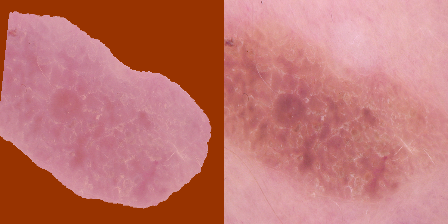

In [ ]:
veure_imatges(train_data)